In [25]:
import cv2
import glob
import numpy as np

In [51]:
from keras.layers import Input, merge, Concatenate, Dense, Dropout, Conv2D, Add, Dot, Lambda, Conv2DTranspose, Dot, Activation, Reshape, BatchNormalization, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Multiply, LeakyReLU, Flatten, MaxPool2D 
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.models import Model
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


In [44]:
img_paths = glob.glob('./train2017/00000000[012345][0123456789][0123456789][0123456789].jpg')

In [45]:
len(img_paths)

1168

In [50]:
for img_path in img_paths:
    img = cv2.imread(img_path)
    x,y,_ = img.shape
    margin = (y-x)//2
    #print(img_path.split('/')[-1])
    img = img[:,margin:y-margin]
    img = cv2.resize(img, (128,128))
    cv2.imwrite('./cleaned-data/' + img_path.split('/')[-1], img)

In [85]:
def build_encoder(input_shape, name='encoder'):
    input_layer = Input(shape=input_shape)
    
    # first encoding block
    encode1 = Conv2D(8, 3, padding='same', activation='relu')(input_layer)
    encode1 = Conv2D(8, 3, padding='same', activation='relu')(encode1)
    encode1 = MaxPool2D()(encode1)
    
    # Second encoding block
    encode2 = Conv2D(16, 3, padding='same', activation='relu')(encode1)
    encode2 = Conv2D(16, 3, padding='same', activation='relu')(encode2)
    encode2 = MaxPool2D()(encode2)
    
    # Third encoding block
    encode3 = Conv2D(32, 3, padding='same', activation='relu')(encode2)
    encode3 = Conv2D(32, 3, padding='same', activation='relu')(encode3)
    encode3 = MaxPool2D()(encode3)
    
    output_layer = encode3
    return Model(input_layer, output_layer, name=name)

In [86]:
encoder = build_encoder((128,128,3))
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 128, 128, 8)       224       
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 128, 128, 8)       584       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 64, 64, 16)        1168      
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 64, 64, 16)        2320      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 32, 32, 16)        0         
__________

In [87]:
def build_decoder(input_shape, name='decoder'):
    input_layer = Input(shape=input_shape)
    
    # first decoding block
    decode1 = UpSampling2D()(input_layer)
    decode1 = Conv2D(16, 3, padding='same', activation='relu')(decode1)
    decode1 = Conv2D(16, 3, padding='same', activation='relu')(decode1)
    
    
    # Second decoding block
    decode2 = UpSampling2D()(decode1)
    decode2 = Conv2D(8, 3, padding='same', activation='relu')(decode2)
    decode2 = Conv2D(8, 3, padding='same', activation='relu')(decode2)
    
    
    # Third decoding block
    decode3 = UpSampling2D()(decode2)
    decode3 = Conv2D(4, 3, padding='same', activation='relu')(decode3)
    decode3 = Conv2D(3, 3, padding='same', activation='relu')(decode3)
    
    
    output_layer = decode3
    return Model(input_layer, output_layer, name=name)

In [88]:
decoder = build_decoder((16,16,32))
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 16, 16, 32)        0         
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 32, 32, 16)        2320      
_________________________________________________________________
up_sampling2d_20 (UpSampling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 64, 64, 8)         1160      
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 64, 64, 8)         584       
__________

In [94]:
def build_autoencoder():
    input_img = Input(shape=(128,128,3))
    latent_representation = encoder(input_img)
    decoded_img = decoder(latent_representation)
    autoencoder = Model(input_img, decoded_img, name="autoencoder")
    return autoencoder

In [95]:
autoencoder = build_autoencoder()

In [96]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 128, 128, 3)       0         
_________________________________________________________________
encoder (Model)              (None, 16, 16, 32)        18184     
_________________________________________________________________
decoder (Model)              (None, 128, 128, 3)       9091      
Total params: 27,275
Trainable params: 27,275
Non-trainable params: 0
_________________________________________________________________


In [107]:
autoencoder.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [103]:
def data_loader(file_path):
    img_paths = glob.glob(file_path + '/*')
    data = []
    for img_path in img_paths:
        
        data.append(cv2.imread(img_path) / 255.0)
    return np.array(data)

In [104]:
X = data_loader('./cleaned-data/')

In [105]:
np.shape(X)

(1168, 128, 128, 3)

In [109]:
history = autoencoder.fit(X,X, epochs=20, batch_size=64, shuffle=True)

Epoch 1/20
1168/1168 [==============================] - 28s 24ms/step - loss: 0.0395 - acc: 0.3741
Epoch 2/20
1168/1168 [==============================] - 28s 24ms/step - loss: 0.0286 - acc: 0.3222
Epoch 3/20
1168/1168 [==============================] - 28s 24ms/step - loss: 0.0244 - acc: 0.3557
Epoch 4/20
1168/1168 [==============================] - 28s 24ms/step - loss: 0.0225 - acc: 0.3667
Epoch 5/20
1168/1168 [==============================] - 27s 23ms/step - loss: 0.0211 - acc: 0.3717
Epoch 6/20
1168/1168 [==============================] - 27s 23ms/step - loss: 0.0202 - acc: 0.3788
Epoch 7/20
1168/1168 [==============================] - 27s 23ms/step - loss: 0.0193 - acc: 0.3812
Epoch 8/20
1168/1168 [==============================] - 27s 23ms/step - loss: 0.0185 - acc: 0.3973
Epoch 9/20
1168/1168 [==============================] - 27s 23ms/step - loss: 0.0179 - acc: 0.4076
Epoch 10/20
1168/1168 [==============================] - 28s 24ms/step - loss: 0.0175 - acc: 0.4173
Epoch 11/

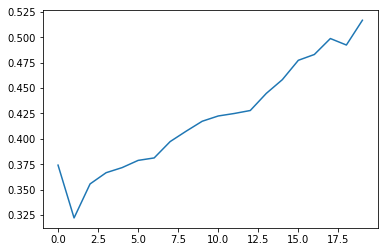

In [115]:
plt.plot(history.history['acc'])

In [128]:
def rgb_imshow(img):
    plt.imshow(cv2.cvtColor(img*255, cv2.COLOR_BGR2RGB))
    plt.show()

img_index = 69
rgb_imshow(X[img_index])

decoded_img = autoencoder.predict(np.array([X[img_index]]))[0]

rgb_imshow(decoded_img)

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/color.hpp:253: error: (-215:Assertion failed) VScn::contains(scn) && VDcn::contains(dcn) && VDepth::contains(depth) in function 'CvtHelper'


In [122]:
decoded_img

array([[[[0.13509443, 0.13617668, 0.20929775],
         [0.16430683, 0.1341766 , 0.19674475],
         [0.19404629, 0.1435808 , 0.20933384],
         ...,
         [0.31039345, 0.24498433, 0.2663633 ],
         [0.28300822, 0.15223086, 0.3472812 ],
         [0.23108506, 0.25252235, 0.27015147]],

        [[0.20823216, 0.18813458, 0.23994002],
         [0.234236  , 0.18196592, 0.24736828],
         [0.24923876, 0.21328235, 0.24935043],
         ...,
         [0.5098297 , 0.38177046, 0.3993932 ],
         [0.38857007, 0.3759736 , 0.49345633],
         [0.21130645, 0.24634132, 0.38560477]],

        [[0.24060237, 0.22312415, 0.2652587 ],
         [0.22180775, 0.1827822 , 0.2622696 ],
         [0.22587103, 0.21989638, 0.2978791 ],
         ...,
         [0.35357445, 0.394129  , 0.389828  ],
         [0.28256956, 0.39301118, 0.43321607],
         [0.3102705 , 0.3222784 , 0.36628094]],

        ...,

        [[0.09880193, 0.10441083, 0.17194518],
         [0.11268328, 0.116405  , 0.09489816]